In [22]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline   # <-- use this one

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Step 2: Load Data
loan = pd.read_csv("raw-data(1).csv")  
loan.head()

C:\Users\JOY\AppData\Local\Temp\ipykernel_17592\894111657.py:2: DtypeWarning: Columns (9,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  loan = pd.read_csv("raw-data(1).csv")


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,NaN,NaN,46500.0,NaN,NaN,0,0,0,TIER 1,0
1,2,0,1,24.0,1.0,1495.0,28168.0,24.0,2496.0,MO,...,NaN,NaN,28168.0,NaN,NaN,0,0,0,TIER 1,0
2,3,0,0,26.0,0.0,1707.0,38900.0,30.0,1346.0,SC,...,NaN,105000.0,38900.0,34.0,31.0,31,31,16,TIER 1,0
3,4,0,0,24.0,0.0,2128.0,42900.0,24.0,1375.0,SC,...,NaN,NaN,42900.0,NaN,NaN,0,0,0,TIER 1,0
4,5,0,0,27.0,0.0,1824.0,40900.0,30.0,4140.0,MC,...,NaN,NaN,40900.0,NaN,NaN,0,0,0,TIER 1,0


### Step 3: Explore Dataset

In [4]:
loan.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32'],
      dtype='object')

In [5]:
loan.shape

(119528, 32)

In [6]:
rename_dict = {
    "V1": "customer_id",
    "V2": "gender",                   # guess: 0/1 binary
    "V3": "married",                  # guess: 0/1 binary
    "V4": "age",                      # numeric
    "V5": "dependents",               # numeric
    "V6": "income",                   # looks like monthly income
    "V7": "loan_amount",              # loan amount requested
    "V8": "loan_term",                # months
    "V9": "credit_amount",            # outstanding credit?
    "V10": "region_code",             # SC, MC, MO etc.
    "V11": "employment_status",       # guess: missing in preview
    "V12": "education_level",
    "V13": "housing_status",
    "V14": "purpose_of_loan",
    "V15": "credit_history_length",
    "V16": "num_open_accounts",
    "V17": "num_credit_cards",
    "V18": "num_loans",
    "V19": "previous_defaults",
    "V20": "current_default_flag",
    "V21": "asset_value",
    "V22": "collateral_value",
    "V23": "other_income",
    "V24": "coapplicant_income",
    "V25": "total_obligations",
    "V26": "num_late_payments",
    "V27": "num_missed_payments",
    "V28": "public_records_flag",
    "V29": "num_inquiries",
    "V30": "utilization_rate",
    "V31": "risk_tier",               # TIER 1, TIER 2, etc.
    "V32": "default_flag"             # ✅ target variable
}

loan = loan.rename(columns=rename_dict)


In [7]:
loan.columns

Index(['customer_id', 'gender', 'married', 'age', 'dependents', 'income',
       'loan_amount', 'loan_term', 'credit_amount', 'region_code',
       'employment_status', 'education_level', 'housing_status',
       'purpose_of_loan', 'credit_history_length', 'num_open_accounts',
       'num_credit_cards', 'num_loans', 'previous_defaults',
       'current_default_flag', 'asset_value', 'collateral_value',
       'other_income', 'coapplicant_income', 'total_obligations',
       'num_late_payments', 'num_missed_payments', 'public_records_flag',
       'num_inquiries', 'utilization_rate', 'risk_tier', 'default_flag'],
      dtype='object')

In [8]:
loan.head()

,customer_id,gender,married,age,dependents,income,loan_amount,loan_term,credit_amount,region_code,...,other_income,coapplicant_income,total_obligations,num_late_payments,num_missed_payments,public_records_flag,num_inquiries,utilization_rate,risk_tier,default_flag
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,NaN,NaN,46500.0,NaN,NaN,0,0,0,TIER 1,0
1,2,0,1,24.0,1.0,1495.0,28168.0,24.0,2496.0,MO,...,NaN,NaN,28168.0,NaN,NaN,0,0,0,TIER 1,0
2,3,0,0,26.0,0.0,1707.0,38900.0,30.0,1346.0,SC,...,NaN,105000.0,38900.0,34.0,31.0,31,31,16,TIER 1,0
3,4,0,0,24.0,0.0,2128.0,42900.0,24.0,1375.0,SC,...,NaN,NaN,42900.0,NaN,NaN,0,0,0,TIER 1,0
4,5,0,0,27.0,0.0,1824.0,40900.0,30.0,4140.0,MC,...,NaN,NaN,40900.0,NaN,NaN,0,0,0,TIER 1,0


In [9]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119528 entries, 0 to 119527
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            119528 non-null  int64  
 1   gender                 119528 non-null  int64  
 2   married                119528 non-null  int64  
 3   age                    85048 non-null   float64
 4   dependents             85048 non-null   float64
 5   income                 85048 non-null   float64
 6   loan_amount            85048 non-null   float64
 7   loan_term              85048 non-null   float64
 8   credit_amount          85048 non-null   float64
 9   region_code            85048 non-null   object 
 10  employment_status      85048 non-null   float64
 11  education_level        85048 non-null   float64
 12  housing_status         85048 non-null   object 
 13  purpose_of_loan        85048 non-null   object 
 14  credit_history_length  84131 non-nul

In [10]:
loan.isnull().sum()

customer_id                   0
gender                        0
married                       0
age                       34480
dependents                34480
income                    34480
loan_amount               34480
loan_term                 34480
credit_amount             34480
region_code               34480
employment_status         34480
education_level           34480
housing_status            34480
purpose_of_loan           34480
credit_history_length     35397
num_open_accounts         34480
num_credit_cards          34480
num_loans                     0
previous_defaults             0
current_default_flag          0
asset_value               82902
collateral_value              0
other_income             100247
coapplicant_income       100500
total_obligations         15061
num_late_payments        106097
num_missed_payments       99095
public_records_flag           0
num_inquiries                 0
utilization_rate              0
risk_tier                     0
default_

C:\Users\JOY\AppData\Local\Temp\ipykernel_18548\1953954712.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="default_flag", data=loan, palette="Set2")


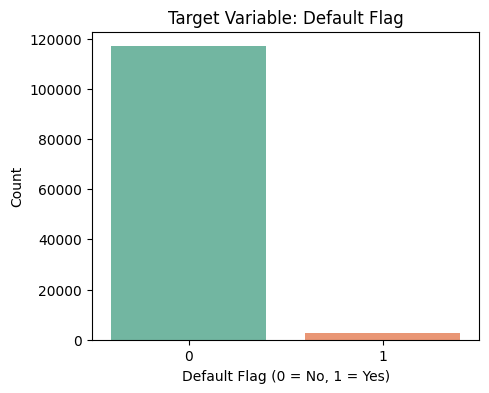

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x="default_flag", data=loan, palette="Set2")
plt.title("Target Variable: Default Flag")
plt.xlabel("Default Flag (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

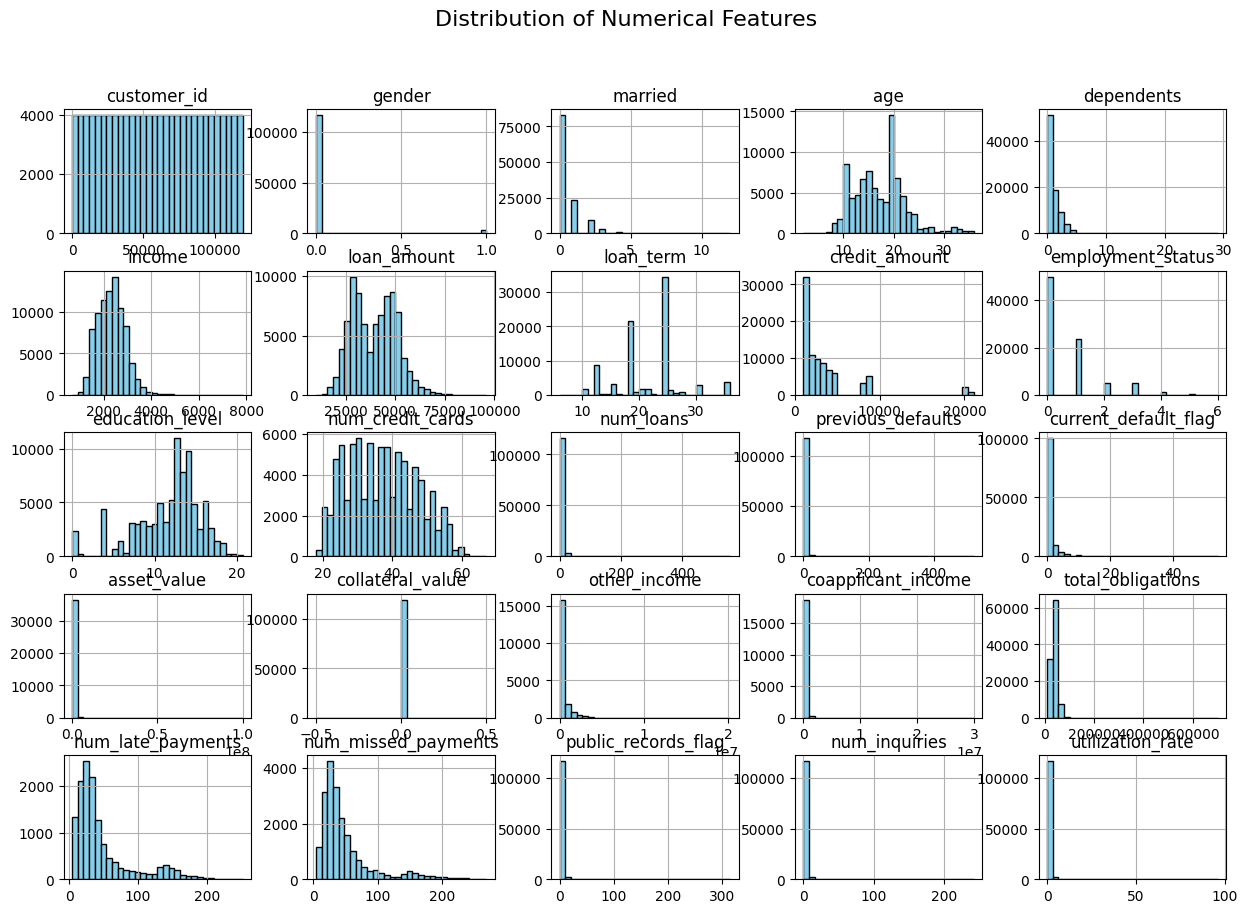

In [11]:


num_cols = loan.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("default_flag")  # remove target

loan[num_cols].hist(figsize=(15, 10), bins=30, color="skyblue", edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

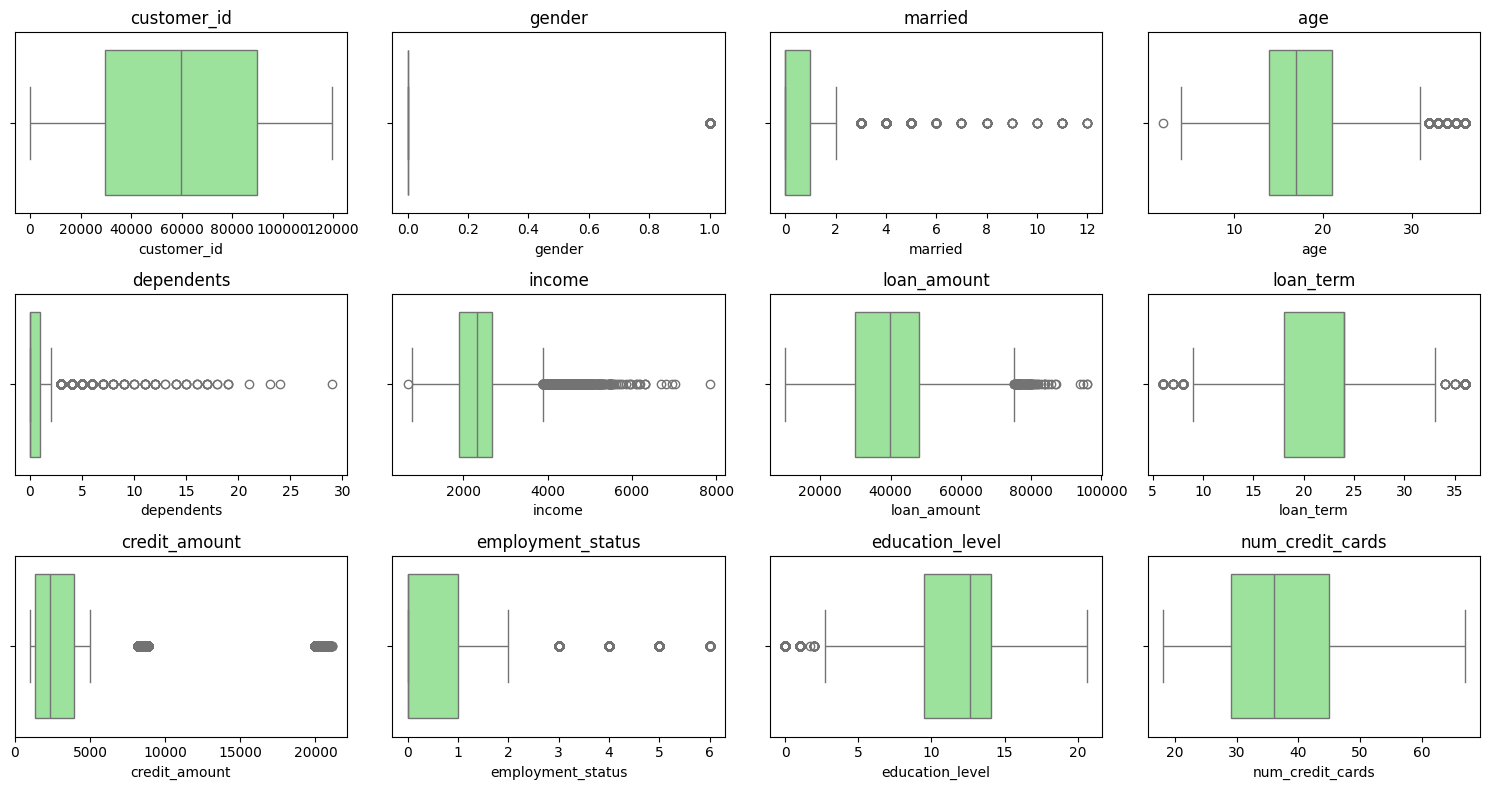

In [37]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols[:12], 1):   # first 12 numeric features
    plt.subplot(3, 4, i)
    sns.boxplot(x=loan[col], color="lightgreen")
    plt.title(col)
plt.tight_layout()
plt.show()

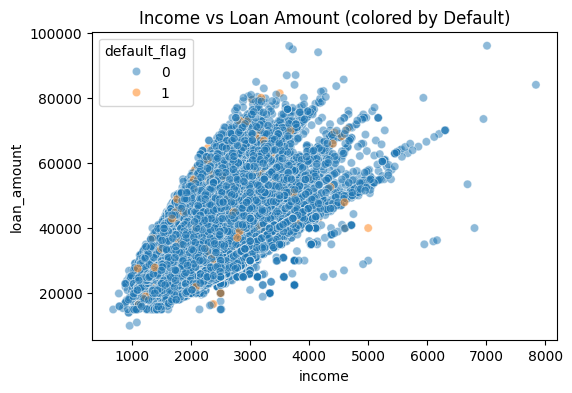

In [39]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="income", y="loan_amount", hue="default_flag", data=loan, alpha=0.5)
plt.title("Income vs Loan Amount (colored by Default)")
plt.show()

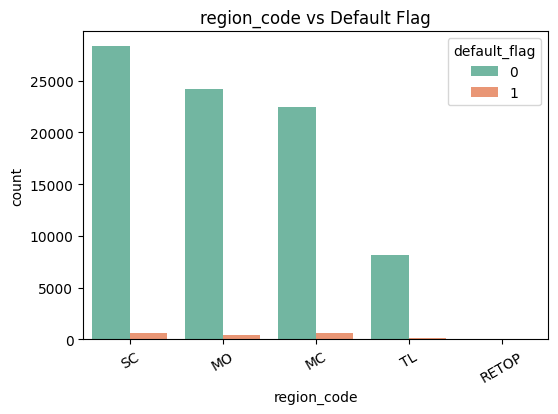

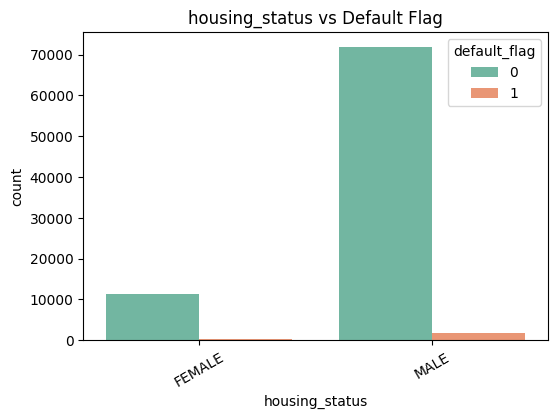

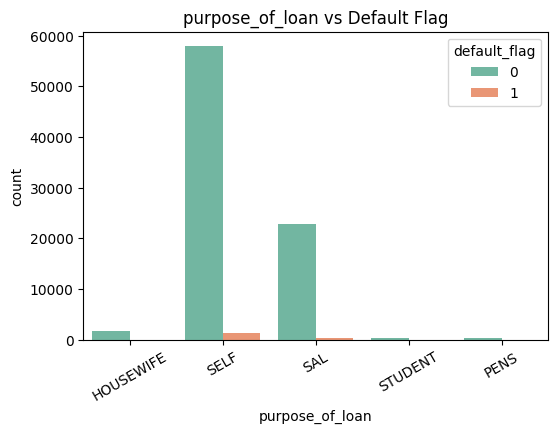

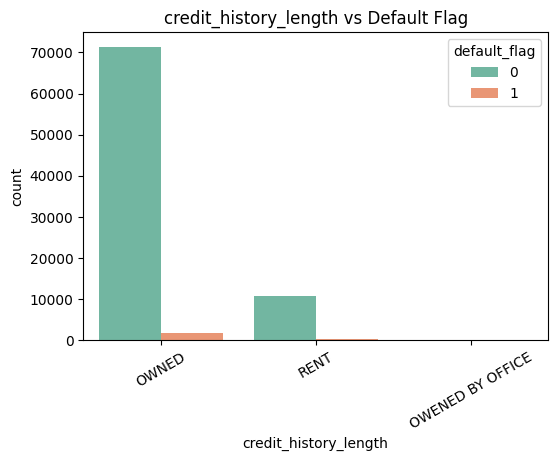

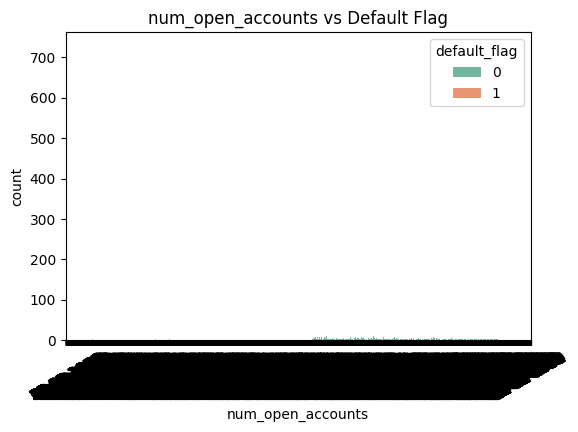

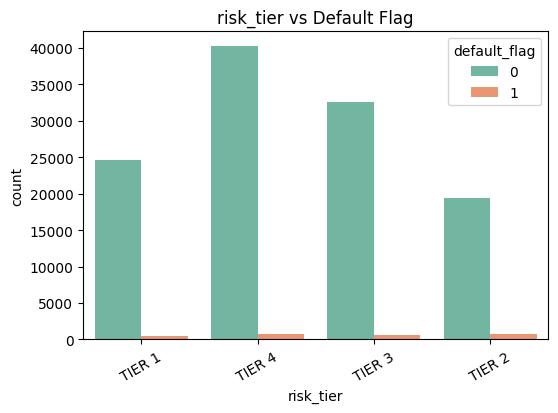

In [38]:
cat_cols = loan.select_dtypes(include="object").columns.tolist()

for col in cat_cols[:6]:   # limit to first 6 for readability
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue="default_flag", data=loan, palette="Set2")
    plt.title(f"{col} vs Default Flag")
    plt.xticks(rotation=30)
    plt.show()

In [17]:
# Step 3: Data Cleaning
# Drop rows with missing target
loan = loan.dropna(subset=["default_flag"])

# Numeric and categorical columns
num_cols = loan.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("default_flag")
cat_cols = loan.select_dtypes(include="object").columns.tolist()

# Impute missing numeric
for col in num_cols:
    loan[col] = loan[col].fillna(loan[col].median())

# Impute missing categorical
for col in cat_cols:
    loan[col] = loan[col].fillna(loan[col].mode()[0])


In [18]:
# Step 5: Encoding + Scaling
X = loan.drop(["default_flag", "customer_id"], axis=1)
y = loan["default_flag"]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
scaler  = StandardScaler()

preprocessor = ColumnTransformer([
    ("num", scaler, num_cols),
    ("cat", encoder, cat_cols)
])


In [19]:
# Step 6: Train/Test Split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [25]:
# Step 7: Models + Pipelines (with SMOTE inside)
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

pipelines = {
    name: Pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),   # <-- SMOTE inside pipeline
        ("model", model)
    ])
    for name, model in models.items()
}


In [26]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

pipelines = {
    name: Pipeline([
        ("preprocessor", preprocessor),
        ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=42)),  # reduce majority
        ("smote", SMOTE(sampling_strategy=1.0, random_state=42)),               # balance after undersampling
        ("model", model)
    ])
    for name, model in models.items()
}


In [27]:
# Step 8: Training & Evaluation
results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)   # pipeline handles preprocessing + SMOTE
    
    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)[:, 1]
    
    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)
    
    results.append([name, acc, roc_auc])
    print(f"--- {name} ---")
    print(classification_report(y_valid, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print("\n")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"])
print(results_df)


c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     23383
           1       0.08      0.63      0.14       523

    accuracy                           0.83     23906
   macro avg       0.53      0.73      0.52     23906
weighted avg       0.97      0.83      0.89     23906

Confusion Matrix:
 [[19403  3980]
 [  194   329]]




c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     23383
           1       0.07      0.68      0.13       523

    accuracy                           0.81     23906
   macro avg       0.53      0.74      0.51     23906
weighted avg       0.97      0.81      0.87     23906

Confusion Matrix:
 [[18920  4463]
 [  169   354]]




c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     23383
           1       0.09      0.59      0.16       523

    accuracy                           0.86     23906
   macro avg       0.54      0.73      0.54     23906
weighted avg       0.97      0.86      0.91     23906

Confusion Matrix:
 [[20298  3085]
 [  217   306]]




c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     23383
           1       0.09      0.63      0.17       523

    accuracy                           0.86     23906
   macro avg       0.54      0.75      0.54     23906
weighted avg       0.97      0.86      0.91     23906

Confusion Matrix:
 [[20220  3163]
 [  191   332]]


                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.825399  0.792705
1        Decision Tree  0.806241  0.802191
2        Random Forest  0.861876  0.795584
3    Gradient Boosting  0.859700  0.824614


c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\JOY\Desktop\Mchine_Learning1\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


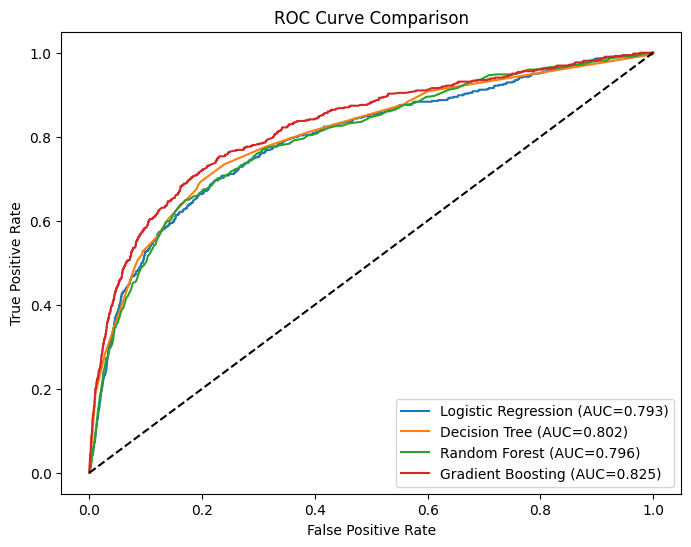

In [28]:
# Step 9: ROC Curve
plt.figure(figsize=(8,6))
for name, pipe in pipelines.items():
    y_proba = pipe.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_valid, y_proba):.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [ ]:
# Step 10: Final Model Training on Full Data + Test Evaluation
best_model = pipelines["Random Forest"]   # pick best model based on Step 8 results
best_model.fit(X_train, y_train)          # pipeline handles preprocessing + SMOTE

# Load test data
test_df = pd.read_csv("test.csv")   # replace with your actual test file

# Drop ID and target to get features
X_test = test_df.drop(["default_flag", "customer_id"], axis=1)
y_test = test_df["default_flag"]

# Evaluate
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))


In [13]:
# Step 5: Train / Validation / Test Split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [15]:
from imblearn.over_sampling import SMOTE


In [16]:
# Step 6a: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


ValueError: could not convert string to float: 'MC'

In [34]:
# Step 6: Models + Pipelines
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

pipelines = {
    name: Pipeline([("preprocessor", preprocessor), ("model", model)])
    for name, model in models.items()
}


In [ ]:
# Step 7: Training & Validation Evaluation
results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)[:, 1]
    
    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)
    
    results.append([name, acc, roc_auc])
    print(f"--- {name} ---")
    print(classification_report(y_valid, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print("\n")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"])
print(results_df)


In [ ]:
# Step 8: ROC Curve (Validation)
plt.figure(figsize=(8,6))
for name, pipe in pipelines.items():
    y_proba = pipe.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_valid, y_proba):.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Validation Set)")
plt.legend()
plt.show()


In [ ]:
# Step 9: Select Best Model (e.g. Random Forest)
best_model_name = results_df.sort_values("ROC-AUC", ascending=False).iloc[0]["Model"]
print("Best Model:", best_model_name)

best_model = pipelines[best_model_name]
best_model.fit(X_train, y_train)


In [ ]:
# Step 10: Final Evaluation on Test Set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

In [ ]:
# ROC Curve on Test Data
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={roc_auc_score(y_test, y_test_proba):.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve (Test Set)")
plt.legend()
plt.show()

In [ ]:
split this code into the different steps so i can paste   # Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Step 2: Load Data
loan = pd.read_csv("raw-data(1).csv")

# Step 2a: Rename Columns
rename_dict = {
    "V1": "customer_id",
    "V2": "gender",
    "V3": "married",
    "V4": "age",
    "V5": "dependents",
    "V6": "income",
    "V7": "loan_amount",
    "V8": "loan_term",
    "V9": "credit_amount",
    "V10": "region_code",
    "V11": "employment_status",
    "V12": "education_level",
    "V13": "housing_status",
    "V14": "purpose_of_loan",
    "V15": "credit_history_length",
    "V16": "num_open_accounts",
    "V17": "num_credit_cards",
    "V18": "num_loans",
    "V19": "previous_defaults",
    "V20": "current_default_flag",
    "V21": "asset_value",
    "V22": "collateral_value",
    "V23": "other_income",
    "V24": "coapplicant_income",
    "V25": "total_obligations",
    "V26": "num_late_payments",
    "V27": "num_missed_payments",
    "V28": "public_records_flag",
    "V29": "num_inquiries",
    "V30": "utilization_rate",
    "V31": "risk_tier",
    "V32": "default_flag"
}
loan = loan.rename(columns=rename_dict)

print(loan.head())

# Step 3: Explore Dataset
print(loan.info())
print(loan.isnull().sum())

sns.countplot(x="default_flag", data=loan, palette="Set2")
plt.title("Target Variable Distribution (Credit Default)")
plt.show()

num_cols = loan.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("default_flag")

loan[num_cols].hist(figsize=(15, 10), bins=30)
plt.show()

plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols[:12], 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=loan[col], color="lightblue")
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(loan[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Step 4: Data Cleaning
loan = loan.dropna(subset=["default_flag"])

for col in num_cols:
    loan[col] = loan[col].fillna(loan[col].median())

cat_cols = loan.select_dtypes(include="object").columns.tolist()
for col in cat_cols:
    loan[col] = loan[col].fillna(loan[col].mode()[0])

# Step 5: Encoding + Scaling
X = loan.drop(["default_flag", "customer_id"], axis=1)
y = loan["default_flag"]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

encoder = OneHotEncoder(drop="first", sparse_output=False)
scaler  = StandardScaler()

preprocessor = ColumnTransformer([
    ("num", scaler, num_cols),
    ("cat", encoder, cat_cols)
])

# Step 6: Train/Test Split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 7: Models + Pipelines
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

pipelines = {
    name: Pipeline([("preprocessor", preprocessor), ("model", model)])
    for name, model in models.items()
}

# Step 8: Training & Evaluation
results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)[:, 1]
    
    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)
    
    results.append([name, acc, roc_auc])
    print(f"--- {name} ---")
    print(classification_report(y_valid, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print("\n")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"])
print(results_df)

# Step 9: ROC Curve
plt.figure(figsize=(8,6))
for name, pipe in pipelines.items():
    y_proba = pipe.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_valid, y_proba):.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [ ]:
# Step 10: Final Model Training on Full Data + Test Evaluation
best_model = pipelines["Random Forest"]   # or whichever scored highest
best_model.fit(X_train, y_train)

# Evaluate on test data (if you have it)
test_df = pd.read_csv("test.csv")   # replace with your actual test file

# Apply same preprocessing (handled automatically inside pipeline)
X_test = test_df.drop(["default_flag", "customer_id"], axis=1)
y_test = test_df["default_flag"]

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))
